# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from scipy import stats
from IPython.display import HTML

np.set_printoptions(suppress=True)

In [54]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $j = 1, ..., J$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [55]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [7]:
def initialize_agents(
        num_agents: int = 100, 
        boundary_size: float = 100.0
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    boundary_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    positions = np.random.uniform(-boundary_size * 0.5, boundary_size * 0.5, (num_agents, 2))
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    orientations = np.random.uniform(0, 2 * np.pi, num_agents)
    
    return positions, orientations

In [56]:
agent_positions, agent_directions = initialize_agents(boundary_size=room_size)
np.cos(agent_directions)

array([[ 0.5264093 ],
       [ 0.5004875 ],
       [ 0.8032966 ],
       [-0.8912787 ],
       [ 0.8759352 ],
       [-0.89904433],
       [ 0.4725748 ],
       [-0.9750324 ],
       [-0.8698092 ],
       [-0.9135189 ],
       [ 0.6402145 ],
       [ 0.89513695]], dtype=float32)

Text(0, 0.5, 'y')

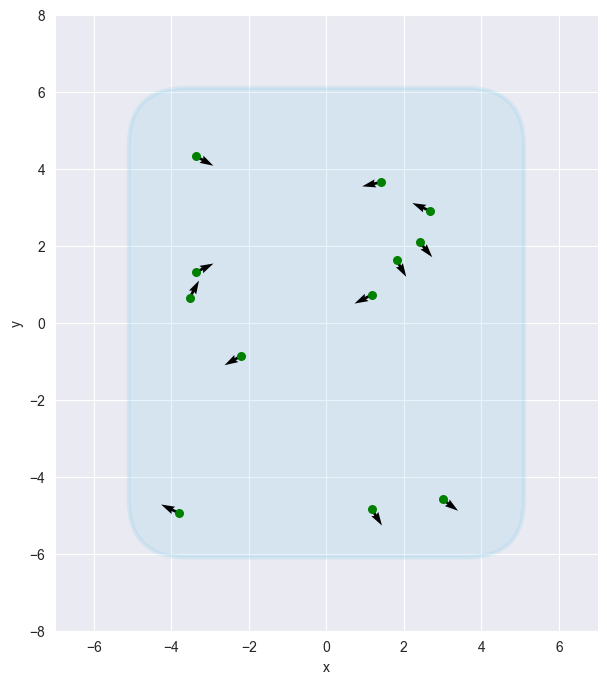

In [57]:
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_directions), np.sin(agent_directions), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.set_xlim([-7, 7])
ax.set_ylim([-8, 8])
ax.set_xlabel('x')
ax.set_ylabel('y')

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [64]:
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    environment_size : float, default: 50.0
        Size of the environment for the generation of beacons.
    
    Returns
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = np.random.uniform(-room_sensing_range * 0.5, room_sensing_range * 0.5, size=(num_beacons, 2))
    return beacons

In [65]:
beacon_positions = initialize_beacons(num_beacons=6, room_sensing_range=world_size)
beacon_positions

array([[ -1.67943343,  -0.23836843],
       [ -2.46262895,   3.93469523],
       [ -3.8878074 ,  -8.23378974],
       [  9.68740198,   5.12821082],
       [  5.0523001 , -11.38435313],
       [  4.57129722,   5.94357728]])

Text(0, 0.5, 'y')

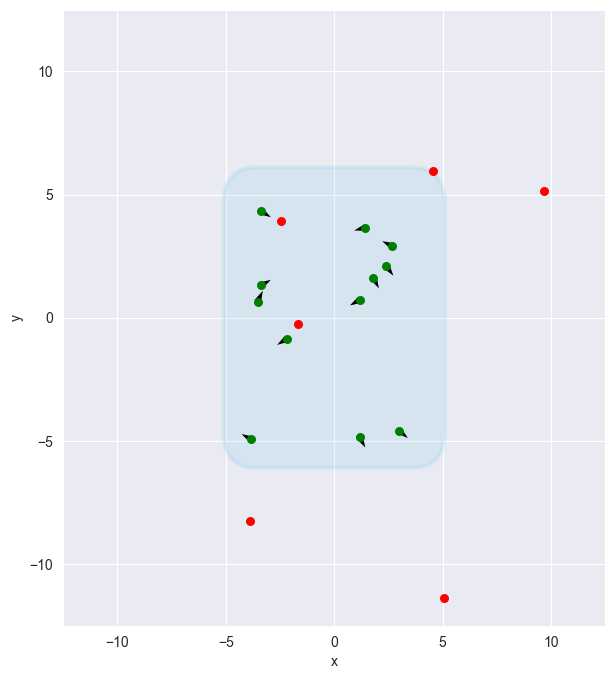

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_directions), np.sin(agent_directions), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.scatter(beacon_positions[:, 0], beacon_positions[:, 1], c='r', s=30)
ax.set_xlim([-0.5 * world_size, 0.5 * world_size])
ax.set_ylim([-0.5 * world_size, 0.5 * world_size])
ax.set_xlabel('x')
ax.set_ylabel('y')

## Internal Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [69]:
def internal_influence(
    noise: float = 0.1, 
    target_position: np.ndarray = np.array([1.0, 1.0])
) -> np.ndarray:
    """
    Generate a drift-diffusion vector in 2D space based on a decision boundary.

    Parameters
    ----------
    noise : float, optional
        The rate of diffusion, which determines the variability of the direction (default is 0.1).
    decision_boundary : np.ndarray, optional
        A 2D point representing the decision boundary (default is np.array([1.0, 1.0])).

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the decision boundary.
    """
    # Calculate the angle towards the decision boundary
    target_angle = np.arctan2(target_position[1], target_position[0])
    
    # Generate a random direction with drift around the target angle
    random_angle = np.random.normal(target_angle, noise)
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    return v

### External Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [70]:
def external_influence(
        positions: np.ndarray, 
        orientations: np.ndarray, 
        sensing_radius: float, 
        noise: float = 0.1
) -> np.ndarray:
    """
    Generate an influence vector based on the angular component of the Vicsek model.

    Parameters
    ----------
    positions : np.ndarray
        Current positions of the agents.
    orientations : np.ndarray
        Current orientations of the agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    noise : float, optional
        The level of noise to add to the average direction (default is 0.1).

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
    num_agents = positions.shape[0]
    new_orientations = np.zeros_like(orientations)

    for i in range(num_agents):
        # Find neighbors within sensing radius
        distances = np.linalg.norm(positions - positions[i], axis=1)
        neighbors_idx = np.where(distances < sensing_radius)[0]
        
        # Calculate the average orientation of neighbors
        mean_orientation = np.arctan2(
            np.mean(np.sin(orientations[neighbors_idx])),
            np.mean(np.cos(orientations[neighbors_idx]))
        )
        
        # Add noise to the average orientation
        noisy_orientation = mean_orientation + np.random.normal(0, noise)
        new_orientations[i] = noisy_orientation
    
    # Convert the orientation to a unit vector in 2D space
    mean_orientation = np.arctan2(np.mean(np.sin(new_orientations)), np.mean(np.cos(new_orientations)))
    influence_vector = np.array([np.cos(mean_orientation), np.sin(mean_orientation)])
    
    return influence_vector

### Putting everything together: combined influences

In [71]:
def update_positions_orientations(
        agent_positions: np.ndarray, 
        agent_rotations: np.ndarray, 
        velocity: float = 1.0, 
        sensing_radius: float = 2.5,
        ddm_vector: np.ndarray = None, 
        vicsek_vector: np.ndarray = None, 
        dt: float = 0.1, 
        influence_weight: float = 0.7
) -> tuple[np.ndarray, np.ndarray]:
    """
    Update the positions and orientations of agents based on velocity and influence vectors.

    Parameters
    ----------
    positions : np.ndarray
        Current positions of the agents.
    orientations : np.ndarray
        Current orientations of the agents.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    influence_vector1 : np.ndarray, optional
        The first influence vector affecting agent orientation. If None, it will be generated using drift-diffusion (default is None).
    influence_vector2 : np.ndarray, optional
        The second influence vector affecting agent orientation. If None, it will be generated using the Vicsek model (default is None).
    delta_t : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence1_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    # Generate influence_vector1 if not provided
    if ddm_vector is None:
        ddm_vector = internal_influence()
    
    # Generate influence_vector2 if not provided
    if vicsek_vector is None:
        vicsek_vector = external_influence(agent_rotations, sensing_radius=sensing_radius)
    
    # Update positions based on current orientations
    agent_positions[:, 0] += velocity * np.cos(agent_rotations) * dt
    agent_positions[:, 1] += velocity * np.sin(agent_rotations) * dt
    
    # Update orientations based on two influence vectors
    ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
    vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
    
    # Combine influences to update orientations with different weights
    agent_rotations += (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
    
    # Ensure orientations are within the range [0, 2*pi]
    agent_rotations = np.mod(agent_rotations, 2 * np.pi)
    
    return agent_positions, agent_rotations

In [72]:
def simulator_fun(
    num_agents: int = 100, 
    boundary_size: float = 100, 
    velocity: float = 1.0, 
    dt: float = 0.1, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    num_timesteps: int = 100
) -> tuple[np.ndarray, np.ndarray]:
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    boundary_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    # Initialize positions and orientations
    positions, orientations = initialize_agents(num_agents, boundary_size)

    # Initialize arrays to store time series of positions and orientations
    positions = [positions.copy()]
    orientations = [orientations.copy()]

    # Simulation loop
    for t in range(num_timesteps):
        ddm_influence = internal_influence(target_position=np.array([1.0, 1.0]))  # Update the drift-diffusion vector each step
        vicsek_influence = external_influence(positions, orientations, sensing_radius)  # Update the Vicsek influence vector each step
        positions, orientations = update_positions_orientations(
            positions, 
            orientations, 
            velocity, 
            sensing_radius,
            ddm_influence, 
            vicsek_influence, 
            dt=dt, 
            influence_weight=influence_weight
        )
        
        # Store positions and orientations for each time step
        positions.append(positions.copy())
        orientations.append(orientations.copy())

    # Convert lists to numpy arrays for easier manipulation
    positions = np.array(positions)
    orientations = np.array(orientations)

    return positions, orientations

# Priors

In [49]:
def prior_fun():
    pass

# Generative Model

In [52]:
prior = bf.simulation.Prior(prior_fun=prior_fun)

simulator = bf.simulation.Simulator(simulator_fun=simulator_fun)

model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False
)

TypeError: simulator_fun() takes 0 positional arguments but 1 was given

# Configurator

In [46]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [47]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

NameError: name 'model' is not defined